In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

/Users/wajih/dato-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# loading data 
train_data_df = pd.read_csv('./data/n26/train.csv')

In [3]:
train_data_df.columns

Index([u'id', u'created', u'updated', u'birthdate', u'birthPlace', u'gender',
       u'lastName', u'nationality', u'passportType', u'signupCompleted'],
      dtype='object')

## Some clean-up of the data and helper functions

This section is revisited and updated each time we find something to fix about the data, or we find a need to a tool function that will be used later or/and 'highly' shared in this notebook

In [4]:
# Cleaning-up (normalize) the birth place
def clean_city_name(city):
    return city.decode('utf-8').lower().title()

def gender_to_str(gender):
    """ Assumes that 0 indexes male, and 1 female """
    if gender == 0:
        return 'm'
    return 'f'
        
train_data_df['birthPlace'] = train_data_df['birthPlace'].apply(lambda item: clean_city_name(item))
train_data_df['gender_str'] = train_data_df['gender'].apply(lambda item: gender_to_str(item))


### Helper functions for grouping by feature

In [5]:
# Helper function to build (count) dictionary for histogram    
def build_hist_dict(data, feature='nationality'):
    """ Build count dictionary which supports items filtering. """
    hist_dict = {}
    for item in data[feature]:
        hist_dict[item] = hist_dict.get(item, 0) + 1
    return hist_dict

def plot_hist_dict(data, feature, top_k=10, color='blue', title=''):
    """ build and plot hist dict. """
    hist_dict = build_hist_dict(data, feature=feature)
    top_k_items = sorted ([(k,v) for k,v in hist_dict.iteritems()],
                              key = lambda x: x[1], reverse= True)[:top_k]
    top_k_items.reverse() # for plotting purpose
    ticks_labels, y = zip(*top_k_items)
    # ticks_labels = [item.decode('utf-8') for item in ticks_labels]
    f, ax = plt.subplots(figsize=(6, int(max(len(top_k_items), 3)/3)))
    ax.grid()
    width = 0.8
    ax.set_yticks(range(top_k))
    ax.set_yticklabels(ticks_labels)
    ax.barh(range(len(y)), list(y), color=color)

def drop_column(df, column_name):
    """ Drops column (with column_name) from dataframe. (if it exists) """
    if column_name in df:
        df.drop(column_name, axis=1, inplace=True)

## Some observation on signupCompleted

### Relation between passportType and signupCompleted

A first examination of the data, unveils that in the most of the case if the passportType exist it tells about the completeness of the signup but let's verify that numerically

In [6]:
# Inspect the correlation between the passportType and signupCompleted 
# it should tell if we can exploit this feature to learn from for a new user
train_data_df['pass_is_not_nan'] =\
    train_data_df['passportType'].apply(lambda item: int(not pd.isnull(item)))
train_data_df ['signup_pass_entred'] = train_data_df.apply(lambda item:\
                                int(item['pass_is_not_nan'] == item['signupCompleted']), axis=1)
print 'in {}% of the cases an entred Pass or Id card is telling the completeness \
of signup process'.\
format(100*sum(train_data_df ['signup_pass_entred'])/float(len(train_data_df)))

in 90.9214285714% of the cases an entred Pass or Id card is telling the completeness of signup process


in other words a naive classifier could be item['pass_is_not_nan'] it self, and it performs pretty well with more than 90% of accuracy, a serious classifier in that case should performs with acccuracy better than 0.9092, let's verify the majority class classifier

### (naive) Majority class classifier

In [7]:
signup_uncompleted = train_data_df[train_data_df['signupCompleted'] == 0]
signup_completed = train_data_df[train_data_df['signupCompleted'] == 1]
signup_uncompleted_prop = float(len(signup_uncompleted))/len(train_data_df)
print 'majority class classifier accuracy: {}'.format(max(signup_uncompleted_prop,
                                                           1-signup_uncompleted_prop))

majority class classifier accuracy: 0.642857142857


pass_is_not_nan performs a way better than the majority class classifier :)

## Signup by gender

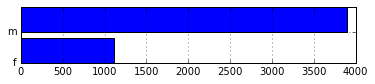

In [8]:
plot_hist_dict(signup_uncompleted, feature='gender_str', top_k=10)

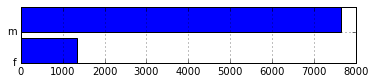

In [9]:
plot_hist_dict(signup_completed, feature='gender_str', top_k=10) 

Seems that the Male gender is more successful in signup than Female gender, let's put some number on this:

In [10]:
complete_signup_mf = build_hist_dict(signup_completed, feature='gender_str')
all_mf = build_hist_dict(train_data_df, feature='gender_str')
for gender in ['m', 'f']:
    print 'signup completed rate for {} gender: {}'.\
        format(gender, float(complete_signup_mf[gender])/all_mf[gender])


signup completed rate for m gender: 0.662825955124
signup completed rate for f gender: 0.549043549044


## Signup by Nationality and birthplace

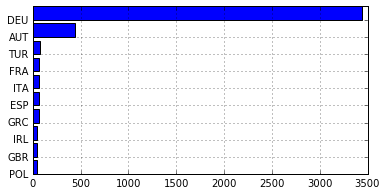

In [11]:
plot_hist_dict(signup_uncompleted, feature='nationality', top_k=10) 

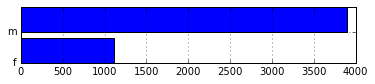

In [12]:
plot_hist_dict(signup_uncompleted, feature='gender_str')

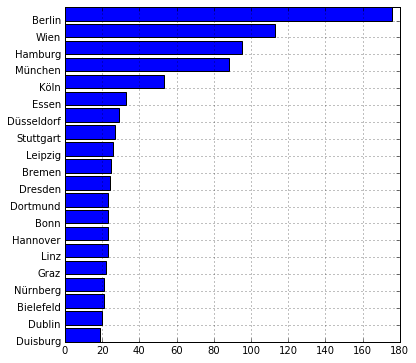

In [13]:
plot_hist_dict(signup_uncompleted, feature='birthPlace', top_k=20) 

## Hacking the timestamp for birthdate and the created and the updated (features)

In [14]:
import scipy.stats as stats

In [15]:
def ts_interval_to_years(ts_interval):
    return float(ts_interval)/(3600000*24*365)
    
train_data_df ['estimated_age_at_creation'] = train_data_df.apply(lambda item:\
                                ts_interval_to_years(item['created'] - item['birthdate']), axis=1)

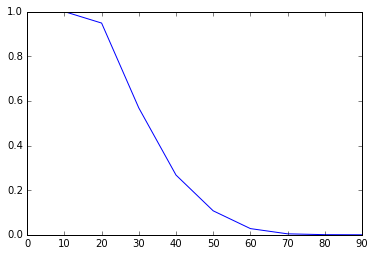

In [16]:
# Sanity check for the estimated age in years,
users_older_than_age_distrib = []
for check_point in np.arange(0,100, 10):
    users_older_than_age_distrib.append((check_point,
                                         len(train_data_df [train_data_df ['estimated_age_at_creation']>check_point])/\
                                         float(len(train_data_df)))) # as proportion of the total data

age, users = zip(*users_older_than_age_distrib)
plt.plot(age, users)

the age estimation seems ok :) according to the (cumulative) distribution of the users age

(array([  3.28286002e-02,   3.96160620e-02,   2.39679429e-02,
          1.58283970e-02,   9.02290741e-03,   3.60555741e-03,
          1.01856997e-03,   2.34361231e-04,   6.30972546e-05,
          9.01389352e-06]),
 array([ 18.01160948,  25.93588452,  33.86015956,  41.7844346 ,
         49.70870965,  57.63298469,  65.55725973,  73.48153478,
         81.40580982,  89.33008486,  97.25435991]),
 <a list of 10 Patch objects>)

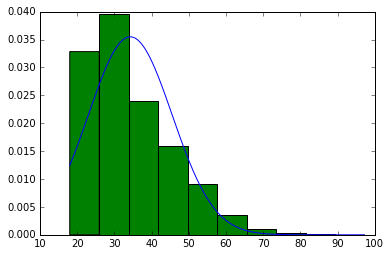

In [17]:
# Approximate with normal distribution
age_at_creation = sorted(train_data_df ['estimated_age_at_creation'])
pdf = stats.norm.pdf(age_at_creation, np.mean(age_at_creation), np.std(age_at_creation))
plt.plot(age_at_creation, pdf)
plt.hist(age_at_creation,normed=True)  

In [18]:
# Pushing further the cleaning removing the users that did not complete the signup should shrink more 
# the distribution removing weight from old people 
# (expecting that for example not serious user will put any number as his age) but also old people could be 
# incofortable with the online forms ....

In [19]:
# Further Hacking (the origine of timestamp)
train_data_df ['created_year'] = train_data_df ['created'].apply(lambda ts:ts_interval_to_years(ts))

(array([  1.80278169e-03,   1.08166901e-02,   7.15103402e-02,
          3.91804553e-01,   6.81451478e-01,   5.90110539e-01,
          1.09068292e+00,   1.43020680e+00,   1.78415294e+00,
          2.36044216e+00]),
 array([ 44.77440388,  44.89326781,  45.01213174,  45.13099567,
         45.2498596 ,  45.36872353,  45.48758745,  45.60645138,
         45.72531531,  45.84417924,  45.96304317]),
 <a list of 10 Patch objects>)

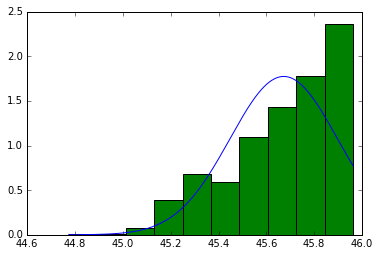

In [20]:
# Estimate the age(activity)/(birthday) of the Company
# Approximate with normal distribution
cp_age = sorted(train_data_df ['created_year'])
pdf = stats.norm.pdf(cp_age, np.mean(cp_age), np.std(cp_age))
plt.plot(cp_age, pdf)
plt.hist(cp_age,normed=True)

The graphics is showing that the company is doing well (at least in term of user visits for signup we will check later after filtering the users that have not completed the signup) and the normal estimation should move to the right/up if you keep going :) . We can also guess: assuming that the data is quite recent and that the age estimation is ok, 
it seems that the origin of the timestamp is set to be 1970. So now we can make the data more human readable (sub sampling the timestamps to a day date).

In [21]:
from datetime import datetime
from datetime import timedelta

def time_stamp_to_date(ts):
    return datetime.strptime('{}'.format('01/01/1970'),  '%d/%m/%Y' ) +\
    timedelta(seconds=float(ts)/1000)

# Here time makes sense
for feature in ['created', 'updated']:
    train_data_df['{}_estimated'.format(feature)] = train_data_df[feature].\
        apply(lambda item: time_stamp_to_date(item))
# Here a date is sfficient
train_data_df['birthdate_estimated'.format(feature)] = train_data_df['birthdate'].\
        apply(lambda item: time_stamp_to_date(item).date())

In [22]:
train_data_df[['created_estimated', 'updated_estimated', 'birthdate_estimated']][:5]

,created_estimated,updated_estimated,birthdate_estimated
0,2015-09-25 16:18:03.001,2015-09-25 16:18:16.235,1990-05-19
1,2015-04-09 20:39:18.175,2015-04-15 17:47:07.256,1985-05-30
2,2015-08-14 06:58:23.921,2015-08-21 19:23:13.813,1970-12-30
3,2015-05-23 12:27:32.310,2015-12-02 18:53:07.609,1976-07-09
4,2015-10-22 14:57:43.964,2015-10-28 17:23:07.296,1982-08-11


## Learning a model that predict signupCompleted 

In [23]:
features = []
def one_hot_encoding(data, feature, top_k=20):
    """ Generates one hot encodin from a feature
        top k will be the top k most frquent values to consider in the model (to limit the number of features) 
        to consider in the one hot encoding """
    hist_dict = build_hist_dict(data, feature=feature)
    top_k_items = sorted ([(k,v) for k,v in hist_dict.iteritems()],
                              key = lambda x: x[1], reverse= True)[:top_k]
    
    gen_features = []
    for feature_item in zip(*top_k_items)[0]:
        feature_to_gen = u'{}_{}_ohe'.format(feature, feature_item)
        data[feature_to_gen] = data[feature].apply(lambda item: int(item == feature_item))
        gen_features.append(feature_to_gen)
    return  gen_features
        



In [24]:
train_data_df.columns

Index([u'id', u'created', u'updated', u'birthdate', u'birthPlace', u'gender',
       u'lastName', u'nationality', u'passportType', u'signupCompleted',
       u'gender_str', u'pass_is_not_nan', u'signup_pass_entred',
       u'estimated_age_at_creation', u'created_year', u'created_estimated',
       u'updated_estimated', u'birthdate_estimated'],
      dtype='object')

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

train_data_df['train_test'] = 'train'

test_data_df = None # Please load test data here (so the added features will be generated for prediction) 

if test_data_df:
    test_data_df['train_test'] = 'test'
    all_df = pd.concat((train_data_df, test_data_df), axis=0, ignore_index=True)
else:
    all_df = train_data_df


# Generate one hot encoding for nationality  and birthplace 
nationality_features = one_hot_encoding(all_df, 'nationality', top_k=20)    
birthplace_features = one_hot_encoding(all_df, 'birthPlace', top_k=20)

target_feature = 'signupCompleted'
learning_features =  [ 'gender', 'pass_is_not_nan',  'created', 'updated']  + nationality_features + birthplace_features
# , 'pass_is_not_nan' , 'estimated_age_at_creation']
# Define (re-split) train/test data  
training_data =  all_df[all_df['train_test']== 'train']
target = training_data[target_feature]
TrainXfeatures = training_data[learning_features]
# Test data
test_data =  all_df[all_df['train_test']== 'test']
TestXfeatures = test_data[learning_features]

# Generate (training/validation) splits ...

from random import shuffle
def gen_split_column(df, fraction=0.5, column_name='split'):

    """ Generates/Defines a random splitting 
        and merges them with columns. 
        instead of copying the data for each split"""
    indxs = range(len(df))
    shuffle(indxs)
    split_point = int(len(df)*fraction)
    df[column_name] = 0 # init values to 0
    df[column_name][indxs[:split_point]] = 1 # define training data (test data will keep 0 value)

def acc_scorer(estimator, X, gt):
    """ Computes classification accuracy """
    return np.mean(map(int, estimator.predict(X) == gt))

def pre_acc_scorer(prediction, gt):
    """ Computes classification accuracy """
    return np.mean(map(int, prediction == gt))

def evaluate_model(model_, label=''):
    """ (Cross validation) multiple splits. """
    train_acc = []
    valid_acc = []
    pass_is_not_nan_acc = []
    for split in splitting_cols:
        train, valid = training_data[training_data[split]==1], training_data[training_data[split]==0]
        model_.fit(train[learning_features].values, train[target_feature].values)
            
        train_acc.append(acc_scorer(model_, train[learning_features].values, train[target_feature].values))
        valid_acc.append(acc_scorer(model_, valid[learning_features].values, valid[target_feature].values))
        pass_is_not_nan_acc.append(pre_acc_scorer(valid['pass_is_not_nan'].values, valid[target_feature].values))
#         if hasattr(model_, 'n_features_'):
#             print 'n feature', model_.n_features_
#         if hasattr(model_, 'estimators_'):
#             print 'estimators', model_.estimators_

#    plt.plot (range(len(valid_mse)), valid_mse, label=label)
#    plt.legend()
    print 'train mean accuracy : {}, valid. mean accuracy : {}, valid. pass_is_not_nan: {}'.\
    format(np.mean(train_acc),  np.mean(valid_acc), np.mean(pass_is_not_nan_acc))
    return np.mean(train_acc),  np.mean(valid_acc)

    


In [34]:
# Generates multiple splitting train/valid configs of the data
splitting_cols = []
for splt_idx in range(20):
    frac = 0.7
    column_name = 'split_{}_frac_{}'.format(splt_idx, frac)
    splitting_cols.append(column_name)
    drop_column(training_data, column_name)
    gen_split_column(training_data, fraction=frac, column_name = column_name)

/Users/wajih/dato-env/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Testing with decision tree

In [35]:
# Decision tree
depths = []
runs = [] 
plt.figure(figsize=(10, 6))
for criterion in ['gini']:#, 'entropy']:
    for depth in np.arange(2, 40,5):
        depths.append(depth)
        dtree_model = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
        runs.append(evaluate_model(dtree_model, label = 'dtree_crit_{}_max_depth_{}'.format(criterion, depth)))


train mean accuracy : 0.931459183673, valid. mean accuracy : 0.929714285714, valid. pass_is_not_nan: 0.908345238095
train mean accuracy : 0.944316326531, valid. mean accuracy : 0.938297619048, valid. pass_is_not_nan: 0.908345238095
train mean accuracy : 0.956770408163, valid. mean accuracy : 0.938928571429, valid. pass_is_not_nan: 0.908345238095
train mean accuracy : 0.972974489796, valid. mean accuracy : 0.935154761905, valid. pass_is_not_nan: 0.908345238095
train mean accuracy : 0.986392857143, valid. mean accuracy : 0.932214285714, valid. pass_is_not_nan: 0.908345238095
train mean accuracy : 0.994005102041, valid. mean accuracy : 0.929178571429, valid. pass_is_not_nan: 0.908345238095
train mean accuracy : 0.997607142857, valid. mean accuracy : 0.928702380952, valid. pass_is_not_nan: 0.908345238095
train mean accuracy : 0.99912244898, valid. mean accuracy : 0.927345238095, valid. pass_is_not_nan: 0.908345238095


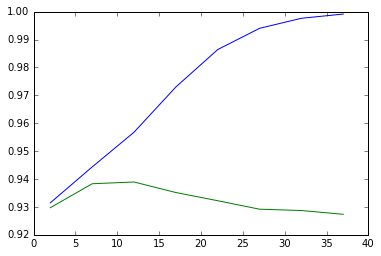

In [36]:
train_perf, valid_perf = zip(*runs)
plt.plot(depths, train_perf)
plt.plot(depths, valid_perf)

### Observation:
decision tree seems to overfit after a depth of 12-13 levels so it is better to learn the model with this depth parameter. The mode outperforms the accuracy of pass_is_not_nan features (while combining it with the other features)

## Testing with random forest (multiple decision trees)

In [ ]:
# Random forest classifier
estims_nbr = []
runs = [] 
print "RandomForest Classifiers:"
for n_estim in np.arange(5,100,10):
    estims_nbr.append(n_estim)
    rfc_model = RandomForestClassifier(n_estimators=n_estim)
    runs.append(evaluate_model(rfc_model, label = 'Random Forest, {} estim'.format(n_estim)))
 
train_perf, valid_perf = zip(*runs)
plt.plot(estims_nbr, train_perf)
plt.plot(estims_nbr, valid_perf)

RandomForest Classifiers:
train mean accuracy : 0.98862755102, valid. mean accuracy : 0.930928571429, valid. pass_is_not_nan: 0.908345238095
train mean accuracy : 0.995908163265, valid. mean accuracy : 0.936464285714, valid. pass_is_not_nan: 0.908345238095
train mean accuracy : 0.997806122449, valid. mean accuracy : 0.938404761905, valid. pass_is_not_nan: 0.908345238095

### Observation:
The Randomforest outperforms the accuracy of the decision tree by 1% and the (pass_is_not_nan) by 3% , and it is also more stable and doesn't show an overfitting at least for the range of the parameters used in the evaluation.

In [30]:
# Building a model with all training data
model = RandomForestClassifier(n_estimators=90)
model.fit(TrainXfeatures.values, target.values)
# Test the model with the test dat
test_pred = None
if len(TestXfeatures):
    test_pred = model.predict(TestXfeatures)